In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
import copy

In [27]:
mnist_train = torchvision.datasets.MNIST("../data", download=True, transform=T.Compose([T.ToTensor()]))
mnist_test = torchvision.datasets.MNIST("../data", download=True, transform=T.Compose([T.ToTensor()]), train=False)
fmnist_train = torchvision.datasets.FashionMNIST("../data", download=True, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]))
fmnist_test = torchvision.datasets.FashionMNIST("../data", download=True, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]), train=False)

In [28]:
mnist_train[0][0].shape, fmnist_train[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

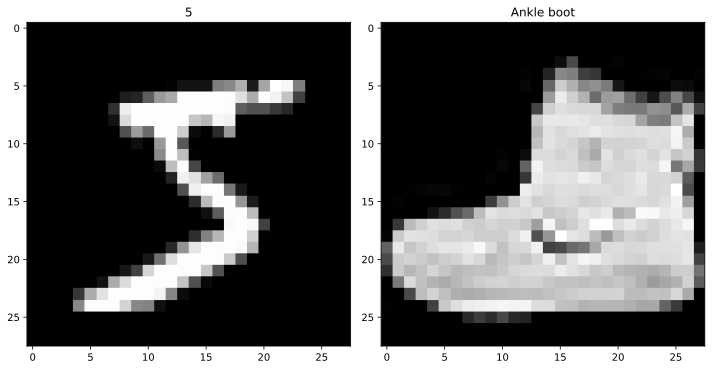

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mnist_train[0][0].permute(1, 2, 0), cmap="gray")
ax[0].set_title(f"{mnist_train[0][1]}")
ax[1].imshow(fmnist_train[0][0].permute(1, 2, 0), cmap="gray")
ax[1].set_title(f"{fmnist_train.classes[fmnist_train[0][1]]}")
plt.tight_layout()
plt.show()

In [30]:
m_train_data = torch.Tensor(np.array([x[0] for x in mnist_train]))
m_train_labels = torch.tensor(np.array([x[1] for x in mnist_train]), dtype=torch.long)
m_test_data = torch.Tensor(np.array([x[0] for x in mnist_test]))
m_test_labels = torch.tensor(np.array([x[1] for x in mnist_test]), dtype=torch.long)
m_train_ds = TensorDataset(m_train_data, m_train_labels)
m_test_ds = TensorDataset(m_test_data, m_test_labels)
m_train_loader = DataLoader(m_train_ds, batch_size=16, shuffle=True, drop_last=True)
m_test_loader = DataLoader(m_test_ds, batch_size=m_test_ds.tensors[0].shape[0])

In [32]:
mx, my = next(iter(m_train_loader))
fx, fy = next(iter(f_train_loader))

mx.shape, my.shape, fx.shape, fy.shape

(torch.Size([16, 1, 28, 28]),
 torch.Size([16]),
 torch.Size([16, 1, 28, 28]),
 torch.Size([16]))

In [33]:
my, fy

(tensor([4, 2, 7, 8, 1, 2, 1, 4, 3, 1, 3, 5, 7, 1, 0, 9]),
 tensor([8, 8, 0, 1, 8, 4, 3, 9, 4, 9, 9, 5, 5, 9, 0, 9]))

In [2]:
def create_mnist_model():
    class MnistNet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.conv1 = nn.Conv2d(1, 64, 3, 1, 1) # 28
            self.bn1 = nn.BatchNorm2d(64) # 28
            self.mp1 = nn.MaxPool2d(2) # 14
            self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) # 14
            self.bn2 = nn.BatchNorm2d(128)
            self.mp2 = nn.MaxPool2d(2) # 7
            self.fc1 = nn.Linear(128*7*7, 128)
            self.dp1 = nn.Dropout(p=.2)
            self.fc2 = nn.Linear(128, 64)
            self.dp2 = nn.Dropout(p=.2)
            self.out = nn.Linear(64, 10)
        def forward(self, x):
            x = torch.relu(self.bn1(self.conv1(x)))
            x = self.mp1(x)
            x = torch.relu(self.bn2(self.conv2(x)))
            x = self.mp2(x)
            x = x.reshape(x.shape[0], -1)
            x = torch.relu(self.dp1(self.fc1(x)))
            x = torch.relu(self.dp2(self.fc2(x)))
            return self.out(x)
    net = MnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer

In [35]:
net, lossfunc, _ = create_mnist_model()
mx, my = next(iter(m_train_loader))
my_pred = net(mx)
print(my_pred.shape)
loss = lossfunc(my_pred, my)
loss

torch.Size([16, 10])


tensor(2.2889, grad_fn=<NllLossBackward0>)

In [12]:
epochs = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [37]:
def train_mnist_model():
    net, lossfunc, optimizer = create_mnist_model()
    net.to(device=device)
    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    for ei in range(epochs):
        net.train()
        batch_acc, batch_loss = [], []
        for x, y in m_train_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            acc = 100*(torch.mean((torch.argmax(y_pred, axis=1)==y).float()).cpu().item())
            batch_acc.append(acc)
            batch_loss.append(loss.cpu().item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del x, y
        train_acc.append(np.mean(batch_acc).item())
        train_loss.append(np.mean(batch_loss).item())

        net.eval()
        with torch.no_grad():
            x, y = next(iter(m_test_loader))
            x = x.to(device=device)
            y = y.to(device=device)
            y_test = net(x)
            loss = lossfunc(y_test, y)
            test_loss.append(loss.cpu().detach().item())
            test_acc.append(100*(torch.mean((torch.argmax(y_test, axis=1)==y).float()).cpu().item()))
            del x, y
        print(f"Epoch {ei}, Train Loss: {train_loss[-1]:.2f}, Test Loss: {test_loss[-1]:.2f}, Train Acc: {train_acc[-1]:.2f}, Test Acc: {test_acc[-1]:.2f}")
    return train_acc, test_acc, train_loss, test_loss, net

In [38]:
train_acc, test_acc, train_loss, test_loss, net = train_mnist_model()

Epoch 0, Train Loss: 0.18, Test Loss: 0.05, Train Acc: 94.70, Test Acc: 98.38
Epoch 1, Train Loss: 0.08, Test Loss: 0.05, Train Acc: 97.79, Test Acc: 98.67
Epoch 2, Train Loss: 0.06, Test Loss: 0.04, Train Acc: 98.37, Test Acc: 98.88
Epoch 3, Train Loss: 0.05, Test Loss: 0.04, Train Acc: 98.69, Test Acc: 98.90
Epoch 4, Train Loss: 0.04, Test Loss: 0.04, Train Acc: 98.90, Test Acc: 99.11
Epoch 5, Train Loss: 0.03, Test Loss: 0.04, Train Acc: 99.07, Test Acc: 98.97
Epoch 6, Train Loss: 0.03, Test Loss: 0.03, Train Acc: 99.17, Test Acc: 99.09
Epoch 7, Train Loss: 0.02, Test Loss: 0.03, Train Acc: 99.34, Test Acc: 99.20
Epoch 8, Train Loss: 0.02, Test Loss: 0.04, Train Acc: 99.35, Test Acc: 99.28
Epoch 9, Train Loss: 0.02, Test Loss: 0.05, Train Acc: 99.48, Test Acc: 99.03


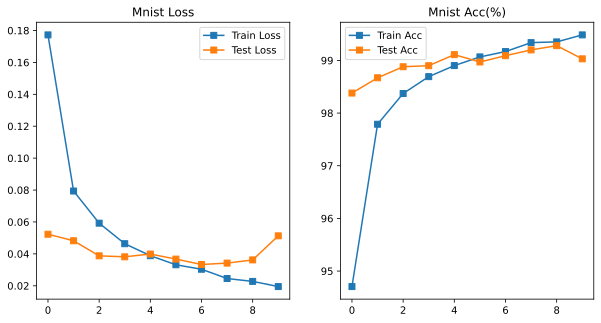

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_loss, "s-")
ax[0].plot(test_loss, "s-")
ax[0].legend(["Train Loss", "Test Loss"])
ax[0].set_title(f"Mnist Loss")

ax[1].plot(train_acc, "s-")
ax[1].plot(test_acc, "s-")
ax[1].legend(["Train Acc", "Test Acc"])
ax[1].set_title(f"Mnist Acc(%)")

plt.show()

In [40]:
torch.save(net.state_dict(), "./mnist_net.pt")

## Loading Trained Mnist Model and Retraining using Fashion data

### Just initial weights were used from the trained model. And all the layers were re-trained with new Fashion Data

In [14]:
mnist_net, _, _ = create_mnist_model()
mnist_net.load_state_dict(torch.load("./mnist_net.pt", weights_only=True))

<All keys matched successfully>

In [15]:
fmnist_train = torchvision.datasets.FashionMNIST("../data", download=True, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]))
fmnist_test = torchvision.datasets.FashionMNIST("../data", download=True, transform=T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]), train=False)

In [16]:
f_train_data = torch.Tensor(np.array([x[0] for x in fmnist_train]))
f_train_labels = torch.tensor(np.array([x[1] for x in fmnist_train]), dtype=torch.long)
f_test_data = torch.Tensor(np.array([x[0] for x in fmnist_test]))
f_test_labels = torch.tensor(np.array([x[1] for x in fmnist_test]), dtype=torch.long)
f_train_ds = TensorDataset(f_train_data, f_train_labels)
f_test_ds = TensorDataset(f_test_data, f_test_labels)
f_train_loader = DataLoader(f_train_ds, batch_size=16, shuffle=True, drop_last=True)
f_test_loader = DataLoader(f_test_ds, batch_size=f_test_ds.tensors[0].shape[0])

In [17]:
fx, fy = next(iter(f_test_loader))
# fx = fx.to(device=device)
# fy = fy.to(device=device)
mnist_net.eval()
with torch.no_grad():
    fy_test = mnist_net(fx)
    fashion_acc = 100*torch.mean((torch.argmax(fy_test, axis=1)==fy).float()).cpu().item()
print(f"MnistNet performance on Fashion Data: {fashion_acc:.2f}")

MnistNet performance on Fashion Data: 11.41


In [18]:
epochs = 2
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [19]:
fnet, lossfunc, optimizer = create_mnist_model() # taking a fresh instance of MnistNet and copying tained model weights

for target, source in zip(fnet.named_parameters(), mnist_net.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

In [20]:
def train_fmnist_model(net, lossfunc, optimizer):
    net.to(device=device)
    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    for ei in range(epochs):
        net.train()
        batch_acc, batch_loss = [], []
        for x, y in f_train_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            acc = 100*(torch.mean((torch.argmax(y_pred, axis=1)==y).float()).cpu().item())
            batch_acc.append(acc)
            batch_loss.append(loss.cpu().item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc.append(np.mean(batch_acc).item())
        train_loss.append(np.mean(batch_loss).item())

        net.eval()
        with torch.no_grad():
            x, y = next(iter(f_test_loader))
            x = x.to(device=device)
            y = y.to(device=device)
            y_test = net(x)
            loss = lossfunc(y_test, y)
            test_loss.append(loss.cpu().detach().item())
            test_acc.append(100*(torch.mean((torch.argmax(y_test, axis=1)==y).float()).cpu().item()))
        print(f"Epoch {ei}, Train Loss: {train_loss[-1]:.2f}, Test Loss: {test_loss[-1]:.2f}, Train Acc: {train_acc[-1]:.2f}, Test Acc: {test_acc[-1]:.2f}")
    return train_acc, test_acc, train_loss, test_loss, net

In [21]:
train_acc, test_acc, train_loss, test_loss, finea_tuned_net = train_fmnist_model(fnet, lossfunc, optimizer)

Epoch 0, Train Loss: 0.67, Test Loss: 0.33, Train Acc: 78.16, Test Acc: 88.12
Epoch 1, Train Loss: 0.35, Test Loss: 0.28, Train Acc: 87.51, Test Acc: 90.04


In [22]:
snet, lossfunc, optimizer  = create_mnist_model()
s_train_acc, s_test_acc, s_train_loss, s_test_loss, scratch_tuned_net = train_fmnist_model(snet, lossfunc, optimizer)

Epoch 0, Train Loss: 0.46, Test Loss: 0.32, Train Acc: 83.56, Test Acc: 88.58
Epoch 1, Train Loss: 0.31, Test Loss: 0.27, Train Acc: 89.17, Test Acc: 90.23


In [23]:
# Scratch did better as model is already sophisticated and large